In [ ]:
# https://github.com/ferretj/temporal-ensembling/blob/master/mnist_eval.py
import numpy as np
import os
from timeit import default_timer as timer
from datetime import datetime

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as tf
from torch.nn.utils import weight_norm

import matplotlib
matplotlib.use('Agg')
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt

In [ ]:
# Loss 저장
def save_losses(losses, sup_losses, unsup_losses, fname, labels=None):
    plt.style.use('ggplot')
    
    # color palette from Randy Olson
    colors = [
        (31, 119, 180),
        (174, 199, 232),
        (255, 127, 14), 
        (255, 187, 120),    
        (44, 160, 44),
        (152, 223, 138),
        (214, 39, 40),
        (255, 152, 150),    
        (148, 103, 189),
        (197, 176, 213), 
        (140, 86, 75),
        (196, 156, 148),    
        (227, 119, 194),
        (247, 182, 210),
        (127, 127, 127),
        (199, 199, 199),    
        (188, 189, 34),
        (219, 219, 141),
        (23, 190, 207),
        (158, 218, 229)]

    colors = [(float(c[0]) / 255, float(c[1]) / 255, float(c[2]) / 255) for c in colors]

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    for i in range(3):
        axs[i].tick_params(axis="both", which="both", bottom="off", top="off",    
                           labelbottom="on", left="off", right="off", labelleft="on")
    for i in range(len(losses)):
        axs[0].plot(losses[i], color=colors[i])
        axs[1].plot(sup_losses[i], color=colors[i])
        axs[2].plot(unsup_losses[i], color=colors[i])
    axs[0].set_title('Overall loss', fontsize=14)
    axs[1].set_title('Supervised loss', fontsize=14)
    axs[2].set_title('Unsupervised loss', fontsize=14)
    if labels is not None:
        axs[0].legend(labels)
        axs[1].legend(labels)
        axs[2].legend(labels)
    plt.savefig(fname)

In [ ]:
def save_seed_samples(fname, indices):
    train_dataset, test_dataset = prepare_mnist()
    imgs = train_dataset.data[indices.numpy().astype(int)]
    
    plt.style.use('classic')
    fig = plt.figure(figsize=(15, 60))
    gs = gsp.GridSpec(20, 5, width_ratios=[1, 1, 1, 1, 1],
                      wspace=0.0, hspace=0.0)
    for ll in range(100):
        i = ll // 5
        j = ll % 5
        img = imgs[ll].numpy()
        ax = plt.subplot(gs[i, j])
        ax.tick_params(axis="both", which="both", bottom="off", top="off",
                       labelbottom="off", left="off", right="off", labelleft="off")
        ax.imshow(img)
    
    plt.savefig(fname)

In [ ]:
class GaussianNoise(nn.Module):
    
    def __init__(self, batch_size, input_shape=(1, 28, 28), std=0.05):
        super(GaussianNoise, self).__init__()
        self.shape = (batch_size,) + input_shape
        self.noise = Variable(torch.zeros(self.shape))#.cuda())
        self.std = std
        
    def forward(self, x):
        self.noise.data.normal_(0, std=self.std)
        return x + self.noise
    
def savetime():
    return datetime.now().strftime('%Y_%m_%d_%H%M%S')


def save_exp(time, losses, sup_losses, unsup_losses,
             accs, accs_best, idxs, **kwargs):
    
    def save_txt(fname, accs, **kwargs):
        with open(fname, 'w') as fp:
            fp.write('GLOB VARS\n')
            fp.write('n_exp        = {}\n'.format(kwargs['n_exp']))
            fp.write('k            = {}\n'.format(kwargs['k']))
            fp.write('MODEL VARS\n')
            fp.write('drop         = {}\n'.format(kwargs['drop']))
            fp.write('std          = {}\n'.format(kwargs['std']))
            fp.write('fm1          = {}\n'.format(kwargs['fm1']))
            fp.write('fm2          = {}\n'.format(kwargs['fm2']))
            fp.write('w_norm       = {}\n'.format(kwargs['w_norm']))
            fp.write('OPTIM VARS\n')
            fp.write('lr           = {}\n'.format(kwargs['lr']))
            fp.write('beta2        = {}\n'.format(kwargs['beta2']))
            fp.write('num_epochs   = {}\n'.format(kwargs['num_epochs']))
            fp.write('batch_size   = {}\n'.format(kwargs['batch_size']))
            fp.write('TEMP ENSEMBLING VARS\n')
            fp.write('alpha        = {}\n'.format(kwargs['alpha']))
            fp.write('data_norm    = {}\n'.format(kwargs['data_norm']))
            fp.write('divide_by_bs = {}\n'.format(kwargs['divide_by_bs']))
            fp.write('\nRESULTS\n')
            fp.write('best accuracy : {}\n'.format(np.max(accs)))
            fp.write('accuracy : {} (+/- {})\n'.format(np.mean(accs), np.std(accs)))
            fp.write('accs : {}\n'.format(accs))
        
    labels = ['seed_' + str(sd) for sd in kwargs['seeds']]
    if not os.path.isdir('exps'):
        os.mkdir('exps')
    time_dir = os.path.join('exps', time)
    if not os.path.isdir(time_dir):
        os.mkdir(time_dir)
    fname_bst = os.path.join('exps', time, 'training_best.png')
    fname_fig = os.path.join('exps', time, 'training_all.png')
    fname_smr = os.path.join('exps', time, 'summary.txt')
    fname_sd  = os.path.join('exps', time, 'seed_samples')
    best = np.argmax(accs_best)
    save_losses([losses[best]], [sup_losses[best]], [unsup_losses[best]], fname_bst)
    save_losses(losses, sup_losses, unsup_losses, fname_fig, labels=labels)
    for seed, indices in zip(kwargs['seeds'], idxs):
        save_seed_samples(fname_sd + '_seed' + str(seed) + '.png', indices)
    save_txt(fname_smr, accs_best, **kwargs)
    
def calc_metrics(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        samples = Variable(samples, volatile=True) 
        labels = Variable(labels) 
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data.view_as(predicted)).sum()

    acc = 100 * float(correct) / total
    return acc


def prepare_mnist():
    # 정규화
    m = (0.1307,)
    st = (0.3081,)
    normalize = tf.Normalize(m, st)
        
    # load 학습 데이터
    train_dataset = datasets.MNIST(
                        root='../data', 
                        train=True, 
                        transform=tf.Compose([tf.ToTensor(), normalize]),  
                        download=True)
    
    # load 테스트 데이터
    test_dataset = datasets.MNIST(
                        root='../data', 
                        train=False, 
                        transform=tf.Compose([tf.ToTensor(), normalize]))
    
    return train_dataset, test_dataset

def ramp_up(epoch, max_epochs, max_val, mult):
    if epoch == 0:
        return 0.
    elif epoch >= max_epochs:
        return max_val
    return max_val * np.exp(mult * (1. - float(epoch) / max_epochs) ** 2)

def weight_schedule(epoch, max_epochs, max_val, mult, n_labeled, n_samples):
    max_val = max_val * (float(n_labeled) / n_samples)
    return ramp_up(epoch, max_epochs, max_val, mult)


In [ ]:
def sample_train(train_dataset, test_dataset, batch_size, k, n_classes,
                 seed, shuffle_train=True, return_idxs=True):
    
    n = len(train_dataset)
    rrng = np.random.RandomState(seed)
    
    cpt = 0
    indices = torch.zeros(k)
    other = torch.zeros(n - k)
    card = k // n_classes
    
    for i in range(n_classes):
        class_items = (train_dataset.train_labels == i).nonzero().squeeze(1)
        n_class = len(class_items)
        rd = np.random.permutation(np.arange(n_class))
        indices[i * card: (i + 1) * card] = class_items[rd[:card]]
        other[cpt: cpt + n_class - card] = class_items[rd[card:]]
        cpt += n_class - card

    other = other.long()
    train_dataset.train_labels[other] = -1

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=4,
                                               shuffle=shuffle_train)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size,
                                              num_workers=4,
                                              shuffle=False)
    
    if return_idxs:
        return train_loader, test_loader, indices 
    return train_loader, test_loader


def temporal_loss(out1, out2, w, labels):
    
    # Mean Squared Error 
    def mse_loss(out1, out2):
        quad_diff = torch.sum((F.softmax(out1, dim=1) - F.softmax(out2, dim=1)) ** 2)
        return quad_diff / out1.data.nelement()
    
    def masked_crossentropy(out, labels):
        cond = (labels >= 0)
        nnz = torch.nonzero(cond)
        nbsup = len(nnz)
        if nbsup > 0:
            masked_outputs = torch.index_select(out, 0, nnz.view(nbsup))
            masked_labels = labels[cond]
            loss = F.cross_entropy(masked_outputs, masked_labels)
            return loss, nbsup
        return Variable(torch.FloatTensor([0.]), requires_grad=False), 0 # Variable(torch.FloatTensor([0.]).cuda(), requires_grad=False), 0
    
    sup_loss, nbsup = masked_crossentropy(out1, labels)
    unsup_loss = mse_loss(out1, out2)
    return sup_loss + w * unsup_loss, sup_loss, unsup_loss, nbsup


def train(model, seed, k=100, alpha=0.6, lr=0.002, beta2=0.99, num_epochs=30,
          batch_size=100, drop=0.5, std=0.15, fm1=16, fm2=32,
          divide_by_bs=False, w_norm=False, data_norm='pixelwise',
          early_stop=None, c=300, n_classes=10, max_epochs=80,
          max_val=30., ramp_up_mult=-5., n_samples=60000,
          print_res=True, **kwargs):
    

    train_dataset, test_dataset = prepare_mnist()
    ntrain = len(train_dataset)

    # 모델 구성
    model #model.cuda()

    # 데이터로더
    train_loader, test_loader, indices = sample_train(train_dataset, test_dataset, batch_size,
                                                      k, n_classes, seed, shuffle_train=False)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

    # 학습
    model.train()
    losses = []
    sup_losses = []
    unsup_losses = []
    best_loss = 20.

    Z = torch.zeros(ntrain, n_classes).float()        # intermediate values # torch.zeros(ntrain, n_classes).float().cuda() 
    z = torch.zeros(ntrain, n_classes).float()        # temporal outputs # torch.zeros(ntrain, n_classes).float().cuda()  
    outputs = torch.zeros(ntrain, n_classes).float()  # current outputs # torch.zeros(ntrain, n_classes).float().cuda()

    for epoch in range(num_epochs):
        t = timer()
        
        # Unsupervised Weight
        w = weight_schedule(epoch, max_epochs, max_val, ramp_up_mult, k, n_samples)
     
        if (epoch + 1) % 10 == 0:
            print('unsupervised loss weight : {}'.format(w))
        
   
        w = torch.autograd.Variable(torch.FloatTensor([w]), requires_grad=False) # torch.autograd.Variable(torch.FloatTensor([w]).cuda(), requires_grad=False)
        
        l = []
        supl = []
        unsupl = []
        for i, (images, labels) in enumerate(train_loader):  
            images = Variable(images) 
            labels = Variable(labels, requires_grad=False) 

            # loss
            optimizer.zero_grad()
            out = model(images)
            zcomp = Variable(z[i * batch_size: (i + 1) * batch_size], requires_grad=False)
            loss, suploss, unsuploss, nbsup = temporal_loss(out, zcomp, w, labels)

            # save outputs and losses
            outputs[i * batch_size: (i + 1) * batch_size] = out.data.clone()
            l.append(loss.data[0])
            supl.append(nbsup * suploss.data.item())
            unsupl.append(unsuploss.data.item())

            # backprop
            loss.backward()
            optimizer.step()

            # loss
            if (epoch + 1) % 10 == 0:
                if i + 1 == 2 * c:
                    print('Epoch [%d/%d], Step [%d/%d], Loss: %.6f, Time (this epoch): %.2f s' 
                           %(epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, np.mean(l), timer() - t))
                elif (i + 1) % c == 0:
                    print('Epoch [%d/%d], Step [%d/%d], Loss: %.6f' 
                           %(epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, np.mean(l)))

        # update temporal ensemble
        Z = alpha * Z + (1. - alpha) * outputs
        z = Z * (1. / (1. - alpha ** (epoch + 1)))

        # handle metrics, losses, etc.
        eloss = np.mean(l)
        losses.append(eloss)
        sup_losses.append((1. / k) * np.sum(supl))  # division by 1/k to obtain the mean supervised loss
        unsup_losses.append(np.mean(unsupl))
        
        # 모델 저장
        if eloss < best_loss:
            best_loss = eloss
            torch.save({'state_dict': model.state_dict()}, 'model_best.pth.tar')

    # 테스트
    model.eval()
    acc = calc_metrics(model, test_loader)
    if print_res:
        print('Accuracy of the network on the 10000 test images: %.2f %%' % (acc))
        
    # 베스트 모델 저장
    checkpoint = torch.load('model_best.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    acc_best = calc_metrics(model, test_loader)
    if print_res:
        print('Accuracy of the network (best model) on the 10000 test images: %.2f %%' % (acc_best))
     
    return acc, acc_best, losses, sup_losses, unsup_losses, indices

In [ ]:
# global vars
n_exp        = 3
k            = 100
# model vars
drop         = 0.5
std          = 0.15
fm1          = 32
fm2          = 64
w_norm       = True
# optim vars
lr           = 0.002
beta2        = 0.99
num_epochs   = 30
batch_size   = 100
# temporal ensembling vars
alpha        = 0.6
data_norm    = 'channelwise'
divide_by_bs = False
# RNG
rng          = np.random.RandomState(42)
seeds        = [rng.randint(200) for _ in range(n_exp)]

In [ ]:
cfg = {'n_exp':3, 'k':100,'drop':0.5,"std":0.15,'fm1':32,'fm2':64,'w_norm':True,'lr':0.002,'beta2':0.99,'num_epochs':30,'batch_size':100,'alpha':0.6,'data_norm':'channelwise','divide_by_bs':False,'rng':np.random.RandomState(42),'seeds':[rng.randint(200) for _ in range(n_exp)]}

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, batch_size, std, p=0.5, fm1=16, fm2=32):
        super(CNN, self).__init__()
        self.fm1   = fm1
        self.fm2   = fm2
        self.std   = std
        self.gn    = GaussianNoise(batch_size, std=self.std)
        self.act   = nn.ReLU()
        self.drop  = nn.Dropout(p)
        self.conv1 = weight_norm(nn.Conv2d(1, self.fm1, 3, padding=1))
        self.conv2 = weight_norm(nn.Conv2d(self.fm1, self.fm2, 3, padding=1))
        self.mp    = nn.MaxPool2d(3, stride=2, padding=1)
        self.fc    = nn.Linear(self.fm2 * 7 * 7, 10)
    
    def forward(self, x):
        if self.training:
            x = self.gn(x)
        x = self.act(self.mp(self.conv1(x)))
        x = self.act(self.mp(self.conv2(x)))
        x = x.view(-1, self.fm2 * 7 * 7)
        x = self.drop(x)
        x = self.fc(x)
        return x


# metrics
accs         = []
accs_best    = []
losses       = []
sup_losses   = []
unsup_losses = []
idxs         = []


ts = savetime()


for i in range(n_exp):
    model = CNN(batch_size, std)
    seed = seeds[i]
    acc, acc_best, l, sl, usl, indices = train(model, seed) 
    accs.append(acc)
    accs_best.append(acc_best)
    losses.append(l)
    sup_losses.append(sl)
    unsup_losses.append(usl)
    idxs.append(indices)



save_exp(ts, losses, sup_losses, unsup_losses,
         accs, accs_best, idxs, **cfg)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


unsupervised loss weight : 0.0009740835053472244
Epoch [10/30], Step [300/600], Loss: 0.084068
Epoch [10/30], Step [600/600], Loss: 0.101494, Time (this epoch): 41.15 s
unsupervised loss weight : 0.0027318847495129677
Epoch [20/30], Step [300/600], Loss: 0.044455
Epoch [20/30], Step [600/600], Loss: 0.049705, Time (this epoch): 42.93 s
unsupervised loss weight : 0.0065534508315721485
Epoch [30/30], Step [300/600], Loss: 0.000119
Epoch [30/30], Step [600/600], Loss: 0.006647, Time (this epoch): 42.45 s


<ipython-input-5-f48b1a57ed45>:68: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  samples = Variable(samples, volatile=True) # samples.cuda()


Accuracy of the network on the 10000 test images: 88.19 %
Accuracy of the network (best model) on the 10000 test images: 87.34 %
unsupervised loss weight : 0.0009740835053472244
Epoch [10/30], Step [300/600], Loss: 0.110121
Epoch [10/30], Step [600/600], Loss: 0.110654, Time (this epoch): 40.79 s
unsupervised loss weight : 0.0027318847495129677
Epoch [20/30], Step [300/600], Loss: 0.034447
Epoch [20/30], Step [600/600], Loss: 0.033028, Time (this epoch): 42.81 s
unsupervised loss weight : 0.0065534508315721485
Epoch [30/30], Step [300/600], Loss: 0.012031
Epoch [30/30], Step [600/600], Loss: 0.009066, Time (this epoch): 41.66 s
Accuracy of the network on the 10000 test images: 86.75 %
Accuracy of the network (best model) on the 10000 test images: 86.75 %
unsupervised loss weight : 0.0009740835053472244
Epoch [10/30], Step [300/600], Loss: 0.080958
Epoch [10/30], Step [600/600], Loss: 0.074070, Time (this epoch): 42.18 s
unsupervised loss weight : 0.0027318847495129677
Epoch [20/30], St

#####  Training Loss

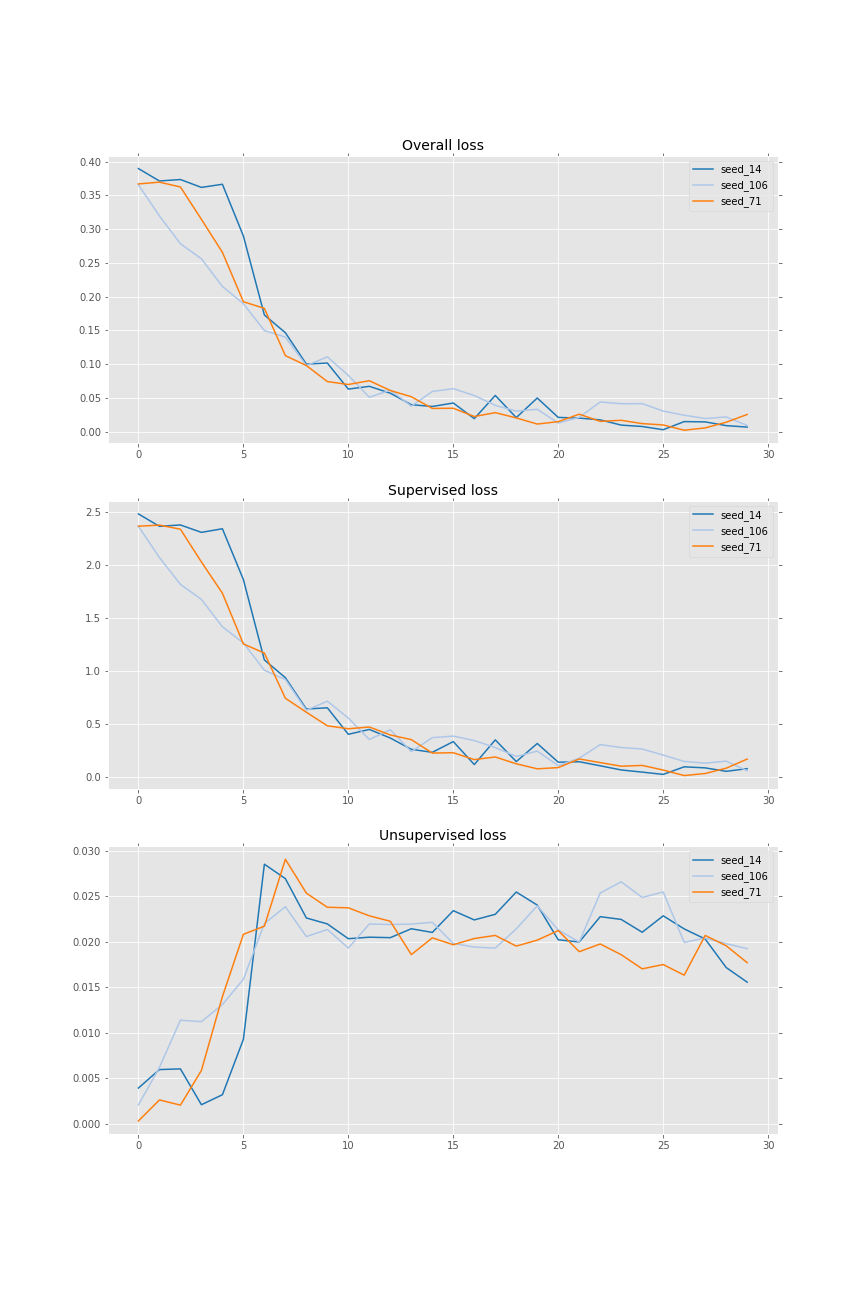

### Training Best

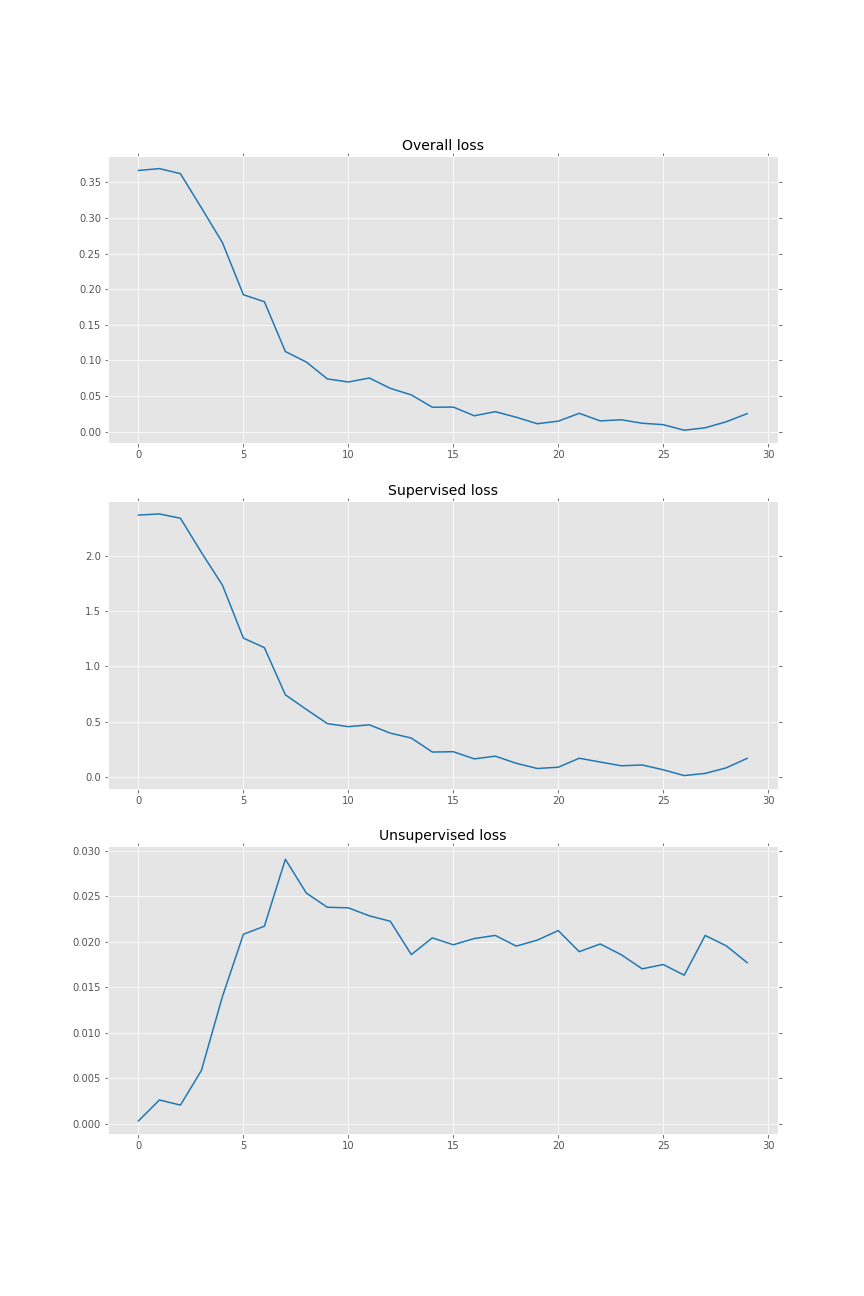